# FNC 8.1 — Exercises 1–6 (Python Notebook)

This notebook answers the programming exercises from **FNC 8.1 — Sparsity and structure**.

- Datasets are downloaded from `tobydriscoll.net` and cached under `./_fnc_assets`.
- Julia functions mentioned in the text (`spdiagm`, `spy`, `lu`, `qr`, `eigs`) are implemented with SciPy/NumPy equivalents.


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib h5py tqdm

import urllib.request
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import h5py
from scipy import sparse
from scipy.sparse.linalg import splu, eigs, eigsh
from tqdm import tqdm

DATA_DIR = Path("./_fnc_assets")
DATA_DIR.mkdir(exist_ok=True)
print("Asset dir:", DATA_DIR.resolve())


def download(url: str, dest: Path, desc: str = "") -> Path:
    '''Download `url` into `dest` if missing.'''
    dest = Path(dest)
    if dest.exists():
        return dest
    print(f"Downloading {desc or url} -> {dest}")
    with urllib.request.urlopen(url) as r, open(dest, "wb") as f:
        total = int(r.headers.get("Content-Length", 0) or 0)
        with tqdm(total=total, unit="B", unit_scale=True) as pbar:
            while True:
                chunk = r.read(1024 * 256)
                if not chunk:
                    break
                f.write(chunk)
                pbar.update(len(chunk))
    return dest


def load_jld2_sparse_csc(path: Path, var: str = "A") -> sparse.csc_matrix:
    '''Load a Julia JLD2 SparseMatrixCSC stored as variable `var`.

    The JLD2 files provided by FNC store a 0-d record `A` with fields
    (m, n, colptr, rowval, nzval), where the last three are HDF5 object
    references.
    '''
    path = Path(path)
    with h5py.File(path, "r") as h5:
        if var not in h5:
            raise KeyError(f"Variable {var!r} not found in {path}")
        ds = h5[var]
        rec = ds[()]
        m = int(rec["m"])
        n = int(rec["n"])

        # Julia is 1-based; SciPy is 0-based.
        colptr = np.array(h5[rec["colptr"]], dtype=np.int64).ravel() - 1
        rowval = np.array(h5[rec["rowval"]], dtype=np.int64).ravel() - 1
        nzval = np.array(h5[rec["nzval"]]).ravel()

        return sparse.csc_matrix((nzval, rowval, colptr), shape=(m, n))


def density(S) -> float:
    m, n = S.shape
    return S.nnz / (m * n)


Asset dir: G:\其他计算机\我的 Mac\Google Drive\250321-Numerical analysis seminar\numerical-analysis-seminar-datahub\solution\code\ch8\_fnc_assets


## Exercise 1 — Build the 50×50 matrices A and B

We construct the two sparse matrices shown in the text:

- `A`: tridiagonal with `-2` on the diagonal and `1` on the first sub-/super-diagonals.
- `B`: same as `A`, but with two wrap-around corner entries `(1,n)` and `(n,1)` equal to `1`.

We verify the structure using `spy` and by printing the 5×5 corner blocks.


A shape: (50, 50) nnz: 148
B shape: (50, 50) nnz: 150


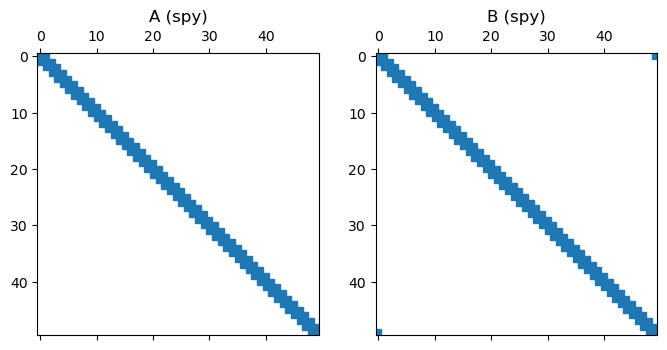


A corner 5×5 blocks:
top-left
[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]
top-right
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
bottom-left
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
bottom-right
[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]

B corner 5×5 blocks:
top-left
[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]
top-right
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
bottom-left
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
bottom-right
[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]


In [2]:
n = 50

# A: tridiagonal
A = sparse.diags(
    diagonals=[np.ones(n - 1), -2 * np.ones(n), np.ones(n - 1)],
    offsets=[-1, 0, 1],
    format="csc",
)

# B: tridiagonal + wrap-around corners
B = sparse.diags(
    diagonals=[
        np.ones(n - 1),
        -2 * np.ones(n),
        np.ones(n - 1),
        np.ones(1),  # (n,1)
        np.ones(1),  # (1,n)
    ],
    offsets=[-1, 0, 1, -(n - 1), (n - 1)],
    format="csc",
)

print("A shape:", A.shape, "nnz:", A.nnz)
print("B shape:", B.shape, "nnz:", B.nnz)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].spy(A, markersize=4)
axes[0].set_title("A (spy)")
axes[1].spy(B, markersize=4)
axes[1].set_title("B (spy)")
plt.show()


def corner_blocks(S, k=5):
    S = S.tocsr()
    return {
        "top-left": S[:k, :k].toarray(),
        "top-right": S[:k, -k:].toarray(),
        "bottom-left": S[-k:, :k].toarray(),
        "bottom-right": S[-k:, -k:].toarray(),
    }

for name, M in [("A", A), ("B", B)]:
    print(f"\n{name} corner 5×5 blocks:")
    blocks = corner_blocks(M)
    for key, blk in blocks.items():
        print(key)
        print(blk)


## Exercise 2 — Density under powers, LU, and QR

Load the `smallworld.jld2` matrix `A` (from Demo 8.1.2) and compute:

- (a) densities of `A`, `A^2`, `A^4`, `A^8`.
- (b) densities of the sparse `L` and `U` factors from `lu`.
- (c) densities of `Q` and `R` from `qr`.

For part (a) we only need the sparsity pattern, so we multiply **boolean** sparse matrices.


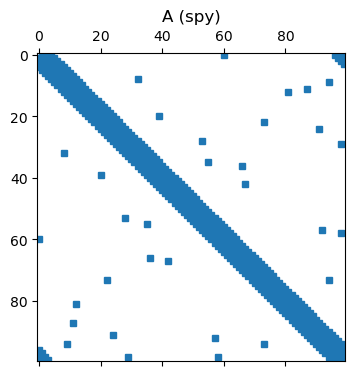

A shape: (100, 100) nnz: 832 density: 0.0832
(a) density(A)  = 0.0832
(a) density(A^2)= 0.2214
(a) density(A^4)= 0.8068
(a) density(A^8)= 1.0
(b) density(L)  = 0.1241
(b) density(U)  = 0.155
(c) density(Q)  = 0.6347
(c) density(R)  = 0.3819


In [3]:
SMALLWORLD_URL = "https://tobydriscoll.net/fnc-julia/_static/resources/smallworld.jld2"
smallworld_path = download(SMALLWORLD_URL, DATA_DIR / "smallworld.jld2", desc="smallworld.jld2")

A_sw = load_jld2_sparse_csc(smallworld_path).astype(float)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.spy(A_sw, markersize=4)
ax.set_title("A (spy)")
plt.show()

print("A shape:", A_sw.shape, "nnz:", A_sw.nnz, "density:", density(A_sw))

# (a) densities of A, A^2, A^4, A^8 using boolean products (pattern only)
A_bool = A_sw.astype(bool)
A2 = A_bool @ A_bool
A4 = A2 @ A2
A8 = A4 @ A4

print("(a) density(A)  =", density(A_bool))
print("(a) density(A^2)=", density(A2))
print("(a) density(A^4)=", density(A4))
print("(a) density(A^8)=", density(A8))

# (b) densities of LU factors
lu = splu(A_sw)
L, U = lu.L, lu.U
print("(b) density(L)  =", density(L))
print("(b) density(U)  =", density(U))

# (c) densities of Q and R (dense QR)
Q, R = np.linalg.qr(A_sw.toarray())
print("(c) density(Q)  =", np.count_nonzero(Q) / Q.size)
print("(c) density(R)  =", np.count_nonzero(R) / R.size)


## Exercise 3 — Roswell adjacency matrix

Load the adjacency matrix `A` (Demo 8.1.1) for the Roswell web graph.

- (a) Verify there are no self-links.
- (b) Verify `A` is not symmetric (directed).
- (c) Count sites with indegree 0.
- (d) Find the site with maximum outdegree.
- (e) Find the site with maximum indegree.
- (f) Compute the fraction of ordered pairs connected by a walk of length ≤ 3.

For parts (c–e), we report site indices in **1-based** numbering (to match the text/Julia).
For part (f), we count reachability by walks of length 1, 2, or 3 (not length 0).


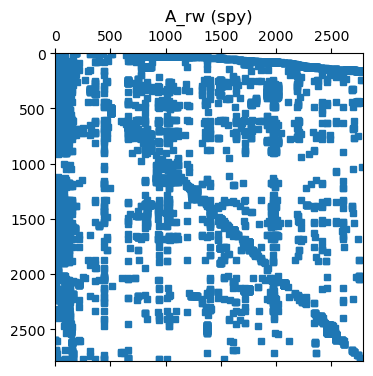

A shape: (2790, 2790) nnz: 8487 density: 0.0010902994565845762
(a) any self-links? False
(b) A is symmetric? False
(c) # sites with indegree 0: 1487
(d) site with max outdegree (1-based): 28 outdegree: 215
(e) site with max indegree (1-based): 5 indegree: 107
(f) fraction connected by a walk of length <= 3: 0.008626173867242199


In [4]:
ROSWELL_URL = "https://tobydriscoll.net/fnc-julia/_static/resources/roswell.jld2"
roswell_path = download(ROSWELL_URL, DATA_DIR / "roswell.jld2", desc="roswell.jld2")

A_rw = load_jld2_sparse_csc(roswell_path).astype(bool)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.spy(A_rw, markersize=4)
ax.set_title("A_rw (spy)")
plt.show()

n = A_rw.shape[0]
print("A shape:", A_rw.shape, "nnz:", A_rw.nnz, "density:", density(A_rw))

# (a) no self-links
has_self_links = bool(A_rw.diagonal().any())
print("(a) any self-links?", has_self_links)

# (b) not symmetric
is_symmetric = (A_rw != A_rw.T).nnz == 0
print("(b) A is symmetric?", is_symmetric)

# (c) indegree / (d) outdegree
outdeg = np.asarray(A_rw.getnnz(axis=1)).ravel()
indeg = np.asarray(A_rw.getnnz(axis=0)).ravel()

print("(c) # sites with indegree 0:", int((indeg == 0).sum()))
print("(d) site with max outdegree (1-based):", int(outdeg.argmax() + 1), "outdegree:", int(outdeg.max()))
print("(e) site with max indegree (1-based):", int(indeg.argmax() + 1), "indegree:", int(indeg.max()))

# (f) fraction of ordered pairs connected by a walk length <= 3
A1 = A_rw
A2 = A1 @ A1
A3 = A2 @ A1
reachable = A1 + A2 + A3  # boolean OR for bool sparse
frac = reachable.nnz / (n * n)
print("(f) fraction connected by a walk of length <= 3:", frac)


## Exercise 4 — Graph Laplacian eigenvalues

Define the graph Laplacian `L = D - A`, where `D` is diagonal with

$$ d_{jj} = \sum_{i=1}^n a_{ij} $$

(i.e., column sums / indegrees, as stated in the text).

Find the **five eigenvalues of `L` with largest magnitude**.


In [5]:
indeg = np.asarray(A_rw.getnnz(axis=0)).ravel()
D = sparse.diags(indeg, offsets=0, format="csc")
L = D - A_rw.astype(float)

vals = eigs(L, k=5, which="LM", return_eigenvectors=False)
vals = np.array(vals)
vals = vals[np.argsort(-np.abs(vals))]

print("Five eigenvalues of L with largest magnitude:")
for v in vals:
    print(v)


Five eigenvalues of L with largest magnitude:
(107.00000000000009+0j)
(88.00000000000026+0j)
(87.05837657168098+0j)
(79.00000000000004+0j)
(75.99982222137955+0j)


## Exercise 5 — Actor–movie matrix

Load the sparse binary matrix `A` (movies × actors) from `actors.jld2`.

- (a) Maximum number of actors appearing in any one movie.
- (b) Number of actors who appeared in exactly three movies.
- (c) Let `C = Aᵀ A`. How many nonzeros does `C` have? Interpret `C_ij`.


In [6]:
ACTORS_URL = "https://tobydriscoll.net/fnc-julia/_static/resources/actors.jld2"
actors_path = download(ACTORS_URL, DATA_DIR / "actors.jld2", desc="actors.jld2")

A_am = load_jld2_sparse_csc(actors_path).astype(np.int32)

m, n = A_am.shape
print("A shape (movies × actors):", A_am.shape, "nnz:", A_am.nnz, "density:", density(A_am))

# For CSC: indices are row indices; indptr splits columns.
row_counts = np.bincount(A_am.indices, minlength=m)
col_counts = np.diff(A_am.indptr)

print("(a) max actors in any one movie:", int(row_counts.max()))
print("(b) # actors in exactly three movies:", int((col_counts == 3).sum()))

C = (A_am.T @ A_am).tocsr()
print("(c) nnz(C = A^T A):", int(C.nnz))

# free memory
del C

print(
    "Interpretation: C[i,j] equals the number of movies in which actors i and j co-appeared;\n"
    "in particular, C[i,i] is the number of movies actor i appeared in."
)


A shape (movies × actors): (127823, 392400) nnz: 1470404 density: 2.93155921211546e-05
(a) max actors in any one movie: 294
(b) # actors in exactly three movies: 21527
(c) nnz(C = A^T A): 30459806
Interpretation: C[i,j] equals the number of movies in which actors i and j co-appeared;
in particular, C[i,i] is the number of movies actor i appeared in.


## Exercise 6 — Helmholtz matrix from a Poisson stencil

The Helmholtz-discretization matrix is

\[ A = \mathrm{poisson}(n) - k^2 I. \]

We implement `poisson(n)` as the standard 2D five-point Laplacian on an `n×n` grid, scaled by `(n+1)^2`:

\[ P = (n+1)^2 (I \otimes T + T \otimes I), \quad T = \operatorname{tridiag}(-1,2,-1). \]


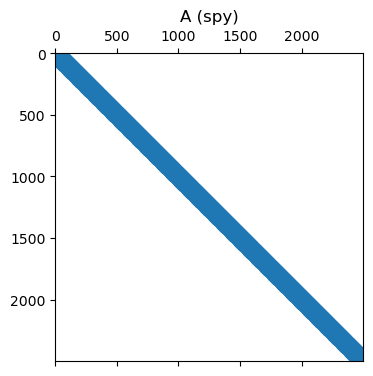

(a) A shape: (2500, 2500)
(a) density(A): 0.001968
(b) four eigenvalues with largest magnitude:
[20787.26703218 20757.7050074  20757.7050074  20728.14298263]
(b) four eigenvalues with smallest magnitude (closest to 0):
[18.73296782 48.2949926  48.2949926  77.85701737]
(c) smallest four eigenvalues of poisson(n):
[19.73296782 49.2949926  49.2949926  78.85701737]
(c) choose k with k^2 in (lam3, lam4): 8.004748902047657
(c) smallest four eigenvalues of A(k_star):
[-44.34303717 -14.78101239 -14.78101239  14.78101239]
=> exactly three negative eigenvalues (first three entries).


In [7]:
def poisson_2d(n: int) -> sparse.csc_matrix:
    T = sparse.diags(
        diagonals=[-np.ones(n - 1), 2 * np.ones(n), -np.ones(n - 1)],
        offsets=[-1, 0, 1],
        format="csc",
    )
    I = sparse.identity(n, format="csc")
    P = sparse.kron(I, T) + sparse.kron(T, I)
    return ((n + 1) ** 2) * P


n = 50
k = 1.0
P = poisson_2d(n).astype(float)
A = P - (k**2) * sparse.identity(n * n, format="csc")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.spy(A, markersize=4)
ax.set_title("A (spy)")
plt.show()

# (a) size and density
print("(a) A shape:", A.shape)
print("(a) density(A):", density(A))

# (b) four largest and four smallest (in magnitude) eigenvalues
largest = eigsh(A, k=4, which="LM", return_eigenvectors=False)
largest = largest[np.argsort(-np.abs(largest))]

# shift-invert around 0 finds eigenvalues closest to 0 (smallest magnitude)
near0 = eigsh(A, k=4, sigma=0, which="LM", return_eigenvectors=False)
near0 = near0[np.argsort(np.abs(near0))]

print("(b) four eigenvalues with largest magnitude:")
print(largest)
print("(b) four eigenvalues with smallest magnitude (closest to 0):")
print(near0)

# (c) choose k so that A has exactly three negative eigenvalues
lam = eigsh(P, k=4, which="SA", return_eigenvectors=False)
lam = np.sort(lam)
lam3, lam4 = lam[2], lam[3]
k_star = float(np.sqrt((lam3 + lam4) / 2))

print("(c) smallest four eigenvalues of poisson(n):")
print(lam)
print("(c) choose k with k^2 in (lam3, lam4):", k_star)

A_star = P - (k_star**2) * sparse.identity(n * n, format="csc")
lamA = eigsh(A_star, k=4, which="SA", return_eigenvectors=False)
lamA = np.sort(lamA)
print("(c) smallest four eigenvalues of A(k_star):")
print(lamA)
print("=> exactly three negative eigenvalues (first three entries).")
